In [170]:
from Helpers import *

def get_Gravity_Matrix(x,g = 9.81,alpha = 0):
    """
    return the gravity matrices terms
    """
    Ms = 52
    Ls = 1.57
    m1 = Ms*0.028
    m2 = Ms*0.022
    l1 = Ls*0.186
    l2 = Ls*(0.146)
    lc1 = l1*0.436
    lc2 = l2*0.682
    G = np.array([g*(m1*lc1*np.cos(x[0]+alpha)+m2*(lc2*np.cos(x[0]+alpha+x[3])+l1*np.cos(x[0]+alpha))),
                    g*m2*lc2*np.cos(x[0]+x[3]+alpha)])
    Gdot = np.array([g*(-m1*lc1*np.sin(x[0]+alpha)*x[1]+m2*(-lc2*np.sin(x[0]+alpha+x[3])*(x[1]+x[4])-l1*np.sin(x[0]+alpha)*x[1])),
                    -g*m2*lc2*np.sin(x[0]+alpha+x[3])*(x[1]+x[4])])
    return G,Gdot

In [152]:
def M1(te,Ms = 52,Ls = 1.57):
    m1 = Ms*0.028
    m2 = Ms*0.022
    l1 = Ls*0.186
    l2 = Ls*(0.146)
    lc1 = l1*0.436
    lc2 = l2*0.682
    I1 = m1*(l1*0.322)**2
    I2 = m2*(l2*0.468)**2
    return np.array([[m1*lc1*lc1+I1+m2*lc2*lc2+I2+m2*(l1*l1+2*l1*lc2*cos(te)),
                      m2*lc2*lc2+I2+m2*l1*lc2*cos(te)],
                      [m2*lc2*lc2+I2+m2*l1*lc2*cos(te),
                       m2*lc2*lc2+I2]])

def dM1(te,os,Ms=52,Ls=1.57):
    m1 = Ms*0.028
    m2 = Ms*0.022
    l1 = Ls*0.186
    l2 = Ls*(0.146)
    lc1 = l1*0.436
    lc2 = l2*0.682
    I1 = m1*(l1*0.322)**2
    I2 = m2*(l2*0.468)**2
    return np.array([[m2*(-2*l1*lc2*sin(te)*os),
                        -m2*l1*lc2*sin(te)*os],
                      [-m2*l1*lc2*sin(te)*os,
                       0]])
def M2(te):
    return np.array([[a1+2*a2*cos(te),a3+a2*cos(te)],
              [a3+a2*cos(te),a3]])

def C1(ts,te,os,oe,Ms=52,Ls=1.57):
    
    m1 = Ms*0.028
    m2 = Ms*0.022
    l1 = Ls*0.186
    l2 = Ls*(0.146)
    lc1 = l1*0.436
    lc2 = l2*0.682
    c = m2*l1*lc2*sin(te)
    C=np.array([[-2*oe*c,-oe*c],[os*c,0]])
    return C@np.array([os,oe])

def dC1(ts,te,os,oe,accs,acce,Ms=52,Ls=1.57):
    
    m1 = Ms*0.028
    m2 = Ms*0.022
    l1 = Ls*0.186
    l2 = Ls*(0.146)
    lc1 = l1*0.436
    lc2 = l2*0.682
    c = m2*l1*lc2*sin(te)
    dc = m2*l1*lc2*cos(te)*oe
    C=np.array([[-2*oe*c,-oe*c],[os*c,0]])
    Cdot = np.array([[-2*(oe*dc+acce*c),-(oe*dc+acce*c)],[(os*dc+accs*c),0]])
    return C@np.array([accs,acce])+Cdot@np.array([os,oe])
def FindBestParam(Angle = 0,i = 0,j=0):
    emin = 1400
    m = 0
    l = 0
    for M in np.linspace(55,85,401):
        for Ls in np.linspace(1.5,1.9,401):
                if abs((M1(Angle,M,Ls)-M2(Angle))[i,j]) < emin:
                    emin = abs((M1(0,M,Ls)-M2(0))[i,j])
                    m = M
                    l = Ls
    print(m,l)

def FindBestParamG(Angle = 0):
    emin = 1400
    m = 0
    l = 0
    for M in np.linspace(50,60,401):
        for Ls in np.linspace(1.5,1.7,401):
                if np.sum((M1(Angle,M,Ls)-M2(Angle))**2) < emin:
                    emin = np.sum((M1(Angle,M,Ls)-M2(Angle))**2)
                    m = M
                    l = Ls
    print(m,l)



In [153]:
def BestAngle():

    for angle in [0,pi/4,pi/2]:
        FindBestParam(angle,0,0)

        FindBestParam(angle,0,1)

        FindBestParam(angle,1,1)

        FindBestParamG(angle)
        print("\n")

In [364]:
def Feedback_Linearization_with_Gravity(Duration = .6,w1 = 1e8,w2 = 1e8,w3 = 1e4,w4 = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,Activate_Noise = False,Side = "Left",newtonfunc = newtonf,newtondfunc = newtondf,Num_iter = 300, ShowJ = False, ShowEstimate = False,Delay = .06,FF = False,ghat = 9.81,alpha = 0,alphahat = 0,Kalman = True):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noises in the model

    Side (String) : Side of the force field ("Left" or "Right")
    
    newtonfunc([thetas,thetae],X,Y) : Function that computes the difference between the change of variable from the angular to cartesian system, and the targetted X,Y position
                                      It's a tool for the newton method to compute the desired joint angles that generate a precise X,Y position of the hand

    newtondfunc([thetas,thetae],X,Y) : Derivative of newtonfunc

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement
    """

    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)
    
    #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1],x0=[-.8,.8])
    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1],x0=[-.3,.5]) 
    if (abs(targets[0] - (np.cos(obj1+obj2)*33+np.cos(obj1)*30))>1) or (abs(targets[1] - np.sin(obj1+obj2)*33-np.sin(obj1)*30)>1):
        print("ERROR")
        return -1
    
    TAUINIT,_ = get_Gravity_Matrix(np.array([st1,0,0,st2,0,0]),alpha=alpha)
    G,_=get_Gravity_Matrix(np.array([st1,0,0,st2,0,0]),alpha = alpha)
    M = M1(st2)
    acc = np.linalg.solve(M,TAUINIT-G)
    x0 = np.array([st1,0,acc[0],st2,0,acc[1],obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))
    sigma2 = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))

    #Incorporation of delay 

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    S = Q

    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = S
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B_basic.T@S@B_basic)@B_basic.T@S@A_basic
        array_L[Num_iter-2-k] = L
        S = A_basic.T@S@(A_basic-B_basic@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_x = np.zeros((Num_iter,Num_Var-2)) 
    array_z = np.zeros((Num_iter,Num_Var)) 
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x = np.zeros(Num_Var-2)
    x[0],x[1] = x0[0],x0[3]
    C = C1(z[0],z[3],z[1],z[4])
    M= M1(z[3])
        #M = np.array([[a1+2*a2*cos(z[3]),a3+a2*cos(z[3])],[a3+a2*cos(z[3]),a3]])

    x = np.array([x0[0],x0[3],x0[1],x0[4],TAUINIT[0],TAUINIT[1]])
    new_x = np.copy(x)

    #Incorporation of delay 

    #Perform the task
    J = 0
    acc = np.zeros(2)
    for k in range(Num_iter-1):

        _,_,Omega_measure,measure_noise = Compute_Noise(Num_Var,1,B)
        Ghat,Ghatdot = get_Gravity_Matrix(z,g = ghat,alpha = alphahat)
        #C = np.array([-zhat[4]*(2*zhat[1]+zhat[4])*a2*np.sin(zhat[3]),zhat[1]*zhat[1]*a2*np.sin(zhat[3])])
        C = C1(zhat[0],zhat[3],zhat[1],zhat[4])
        #M = np.array([[a1+2*a2*cos(zhat[3]),a3+a2*cos(zhat[3])],[a3+a2*cos(zhat[3]),a3]])
        M = M1(zhat[3])
        #Cdot = np.array([-a2*zhat[5]*(2*zhat[1]+zhat[4])*sin(zhat[3])-a2*zhat[4]*(2*zhat[2]+zhat[5])*sin(zhat[3])
        #                 -a2*zhat[4]*zhat[4]*(2*zhat[1]+zhat[4])*cos(zhat[3]),2*zhat[1]*zhat[2]*a2*sin(zhat[3])+zhat[1]*zhat[1]*a2*cos(zhat[3])*zhat[4]])
        Cdot = dC1(zhat[0],zhat[3],zhat[1],zhat[4],zhat[2],zhat[5])
        Mdot = dM1(zhat[3],zhat[4])
        #Mdot = np.array([[-2*a2*sin(zhat[3])*zhat[4],-a2*sin(zhat[3])*zhat[4]],[-a2*sin(zhat[3])*zhat[4],0]])
        O,Omega_measure = Cov_Matrix(M,Num_Var)
        #O = np.zeros((Num_Var,Num_Var))
        Omega_sens = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))
        Omega_sens[:Num_Var,:Num_Var] = O
        # Compute the command through the FL technique
        
        v = -L[k].reshape(np.flip(B_basic.shape))@zhat[:Num_Var]
        u = 1/Kfactor*(M@(v)+Mdot@(np.array([zhat[2],zhat[5]]))+Cdot+Ghatdot+Bdyn@np.array([zhat[2],zhat[5]]))+M@(np.array([zhat[2],zhat[5]]))+C+Ghat+Bdyn@np.array([zhat[1],zhat[4]])
        if ShowJ : J+= u.T@R@u
        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        if Activate_Noise : y[k]+=measure_noise
        
        # Kalman Filter Gains 
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T

        K2 = A@sigma2@H.T@np.linalg.inv(H@sigma2@H.T+Omega_measure*1000)
        sigma2 = Omega_sens + (A - K2@H)@sigma2@A.T

        # Compute the Estimation of the system in the linear system
        
        zhat = A@zhat + B@v
        if Kalman : zhat += K@(y[k]-H@zhat)
        else : zhat += K2@(y[k]-H@zhat)
        
        # Simulate the nonlinear plant 
        
        #C = np.array([-x[3]*(2*x[2]+x[3])*a2*np.sin(x[1]),x[2]*x[2]*a2*np.sin(x[1])])
        C = C1(x[0],x[1],x[2],x[3])
        #M = np.array([[a1+2*a2*cos(x[1]),a3+a2*cos(x[1])],[a3+a2*cos(x[1]),a3]])
        M = M1(x[1])
        
        #Mdot = np.array([[-2*a2*sin(x[1])*x[3],-a2*sin(x[1])*x[3]],[-a2*sin(x[1])*x[3],0]])
        Mdot = dM1(x[1],x[3])
        #print(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))-acc)
        G,Gdot = get_Gravity_Matrix(z,alpha = alpha)
        new_x[0:2] += dt*x[2:4]
        new_x[2:4] += dt*(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C-G)))
        new_x[4:6] += dt*Kfactor*(u-x[4:6])
        
        if Activate_Noise : 
            #new_x[4:6]+=np.ones(2)*motor_noise[2]
            new_x[4:6]+=np.random.normal(0,1e-3,2)
        
        z = np.concatenate((np.array([new_x[0],new_x[2],acc[0],new_x[1],new_x[3],acc[1],z[6],z[7]]),z[:-Num_Var]))
        
        # Transform the new nonlinear state into the coordinates of the linear system
        #C = np.array([-z[4]*(2*z[1]+z[4])*a2*np.sin(z[3]),z[1]*z[1]*a2*np.sin(z[3])])
        C = C1(z[0],z[3],z[1],z[4])
        M= M1(z[3])
        #M = np.array([[a1+2*a2*cos(z[3]),a3+a2*cos(z[3])],[a3+a2*cos(z[3]),a3]])

        G,_ =  get_Gravity_Matrix(z,alpha = alpha)
        acc = np.linalg.solve(M,(new_x[4:6]-Bdyn@(new_x[2:4])-C-G))
        #Stock the true and estimated states

        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()
        array_x[k+1] = new_x[:Num_Var-2].flatten()
        
        x = np.copy(new_x)
        

    if ShowJ : 
        #J+= z.T@Q@z
        #print("Total cost of FL: "+str(J)[:7])
        pass

    #Change of coordinates from angular to cartesian 
    

    X = np.cos(array_z[:,0]+array_z[:,3])*33+np.cos(array_z[:,0])*30
    Y = np.sin(array_z[:,0]+array_z[:,3])*33+np.sin(array_z[:,0])*30

    if ShowEstimate:
        X2 = np.cos(array_zhat[:,0]+array_zhat[:,3])*33+np.cos(array_zhat[:,0])*30
        Y2 = np.sin(array_zhat[:,0]+array_zhat[:,3])*33+np.sin(array_zhat[:,0])*30

    #Plotting
    if alphahat != alpha: color1 = plt.get_cmap('RdPu')((alphahat-alpha+pi/8)/(pi/8))
    elif ghat !=9.81 : color1 = plt.get_cmap('RdPu')((ghat-6)/6)
    else: color1 = "grey"

    if plot : 
        
        #plt.grid(linestyle='--')
        
        #if FF : 
            #plt.plot(np.linspace(-10,10,100),np.ones(100)*FFonset,linestyle = "--",alpha = .7,color = "grey")
        plt.axis("equal")
        plt.ylim(starting_point[1]-3,targets[1]+3)
        color = color1
        ls = "-"
        lw = 2.5
        if alphahat != alpha: plt.plot(X, Y, color=color1, label=r"FL( $\alpha = {:.2f}^\circ$)".format(alphahat / np.pi * 180), linewidth=lw, linestyle=ls)
        elif ghat != 9.81: plt.plot(X, Y, color=color1, label=f"FL( g = {ghat:.2f} m/s²)", linewidth=lw, linestyle=ls)
        else: plt.plot(X, Y, color=color1, label=f"FL(Baseline)", linewidth=lw, linestyle=ls)
        
        if ShowEstimate: 
            plt.plot(X2,Y2,color ="black",label = "Estimation",linewidth = 1,linestyle = "--",alpha = .8)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "orange",marker = "s" , s = 600, alpha= .3)
    if ShowJ : return X,Y,J,array_x
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return X,Y

#X,Y = Feedback_Linearization_with_Gravit
# y(Duration=.6,w1 = 1e7,w2 = 1e7,w3 = 1e4,w4 = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,40],Num_iter = 600)

In [363]:
def PlotReachingGravity(D=20,alpha = 0,Xst = 50,Yst = -25,Duration = .6):    
    r = 1e-6
    w1 = 1e3
    for ghat in [8,9.81,12]:
        X,Y = Feedback_Linearization_with_Gravity(Duration=Duration,w1 = w1,w2 = w1,w3 = 1e3,w4 = 1e3,r1 = r,r2 = r,targets = [Xst,Yst+D],starting_point = [Xst,Yst],Num_iter = 60,Delay=0,Activate_Noise=False,ghat = ghat,alpha=alpha,alphahat = alpha)
    plt.legend()
    plt.show()

    for alphahat in [-pi/18,0,pi/18]:
        X,Y = Feedback_Linearization_with_Gravity(Duration=Duration,w1 = w1,w2 = w1,w3 = 1e3,w4 = 1e3,r1 = r,r2 = r,targets = [Xst,Yst+D],starting_point = [Xst,Yst],Num_iter = 60,Delay=0,Activate_Noise=False,alpha=alpha,alphahat=alpha + alphahat)
    plt.legend()
    plt.show()

def PlotReachingGravityKalman(D=20,alpha = 0,Xst = 50,Yst = -25,Duration = .6):    
    r = 1e-6
    w1 = 1e3

    for Kalman in [True,False]:
        for alphahat in [-pi/12,0,pi/12]:
            X,Y = Feedback_Linearization_with_Gravity(Duration=Duration,w1 = w1,w2 = w1,w3 = 1e3,w4 = 1e3,r1 = r,r2 = r,targets = [Xst,Yst+D],starting_point = [Xst,Yst],Num_iter = 60,Delay=0,Activate_Noise=False,alpha=alpha,alphahat=alpha + alphahat,Kalman = Kalman)
        plt.legend()
        plt.show()

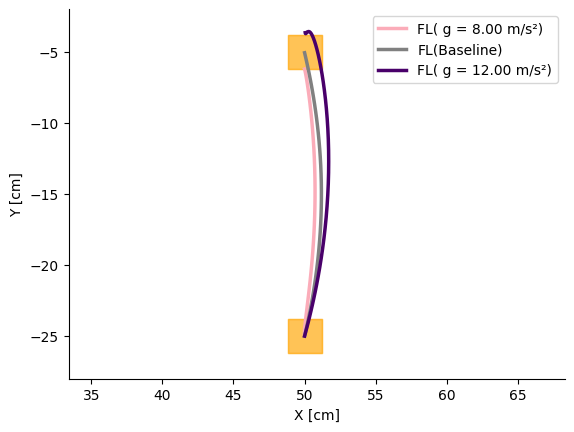

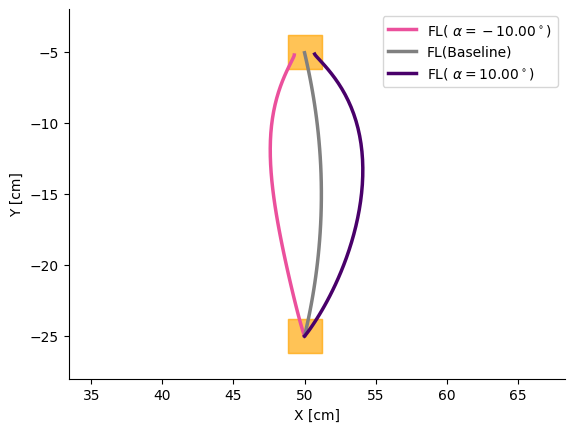

In [340]:
PlotReachingGravity()

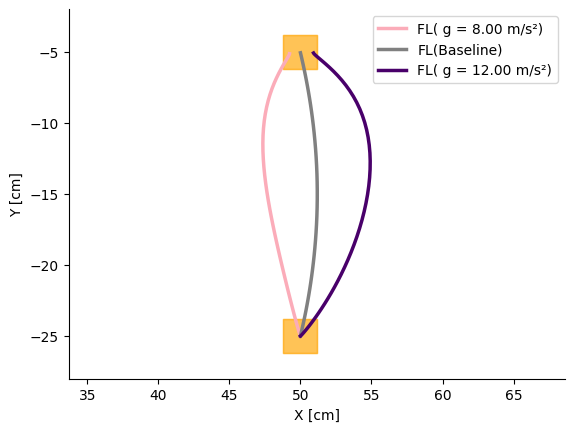

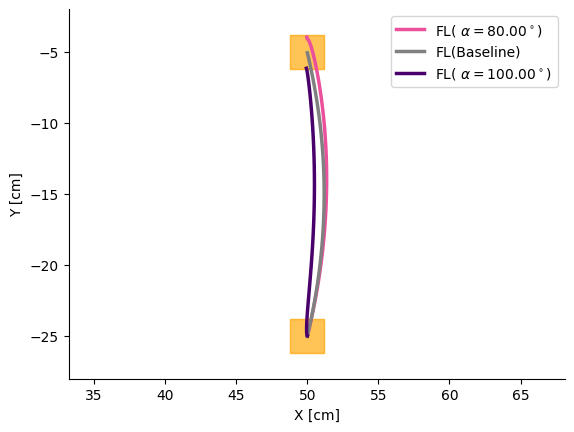

In [339]:
PlotReachingGravity(alpha = pi/2)

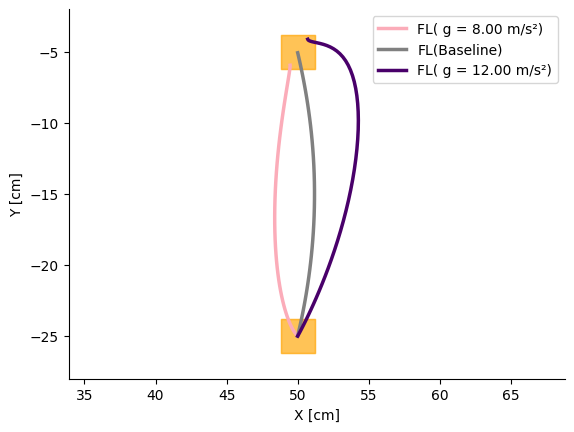

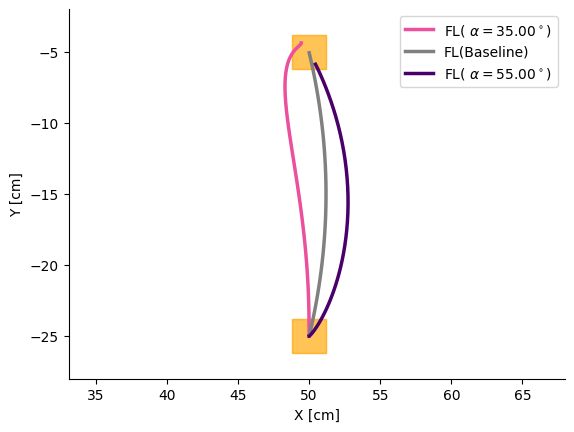

In [334]:
PlotReachingGravity(alpha = pi/4)

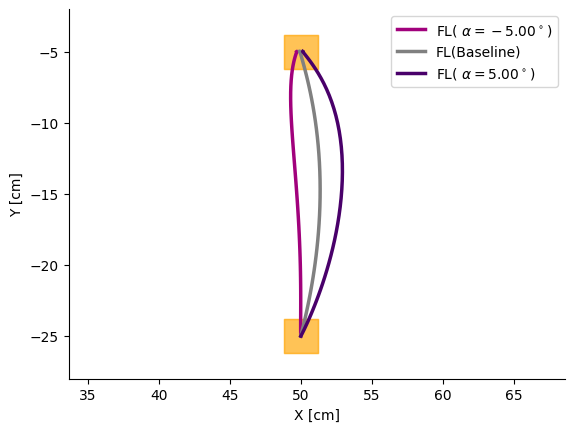

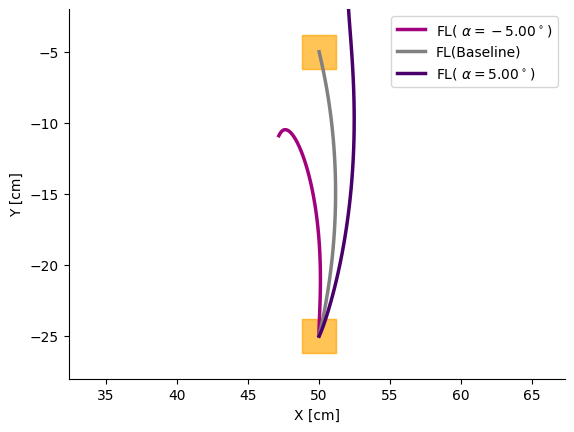

In [345]:
PlotReachingGravityKalman()

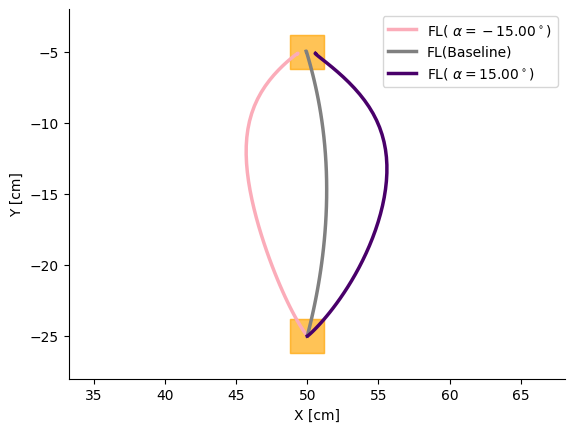

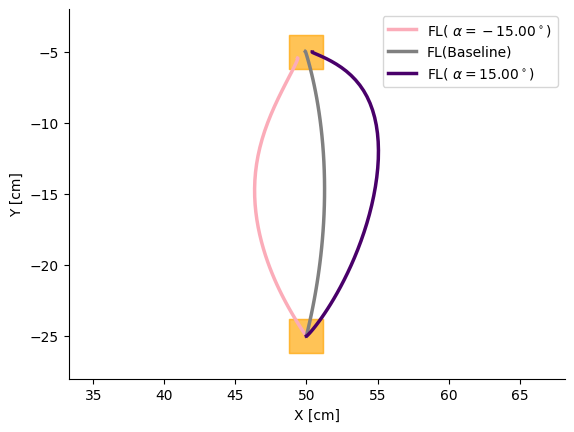

In [366]:
PlotReachingGravityKalman(alpha = 0)